
# Assignment 1 - Image Classification

Daniel Evilsizor



In [ ]:
# Get Data from Kaggle.com

# NOTE: Requires you to have a Kaggle.com account. From your account you can generate an API key.
# It will be provided in kaggle.json. Upload the JSON file to this project BEFORE RUNNING.

# src: https://www.kaggle.com/general/74235

! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download maricinnamon/caltech101-airplanes-motorbikes-schooners
! mkdir caltech101
! unzip caltech101-airplanes-motorbikes-schooners.zip -d caltech101

In [2]:
# load all necessary libraries
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import os

print('Tensorflow', tf.__version__)

Tensorflow 2.9.2


In [10]:
# src: https://www.tensorflow.org/tutorials/load_data/images
train_data = tf.keras.utils.image_dataset_from_directory(
  'caltech101/caltech101_classification',
  validation_split=0.4,
  labels='inferred',
  subset="training",
  seed=123,
  image_size=(200, 300),
  batch_size=32)

test_data = tf.keras.utils.image_dataset_from_directory(
  'caltech101/caltech101_classification',
  validation_split=0.4,
  labels='inferred',
  subset="validation",
  seed=123,
  image_size=(200, 300),
  batch_size=32)

class_names = train_data.class_names
print('Classes:', class_names)

Found 1661 files belonging to 3 classes.
Using 997 files for training.
Found 1661 files belonging to 3 classes.
Using 664 files for validation.
Classes: ['Motorbikes', 'airplanes', 'schooner']


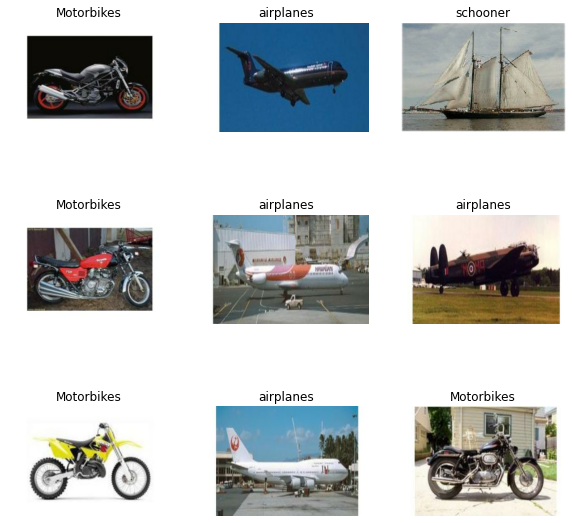

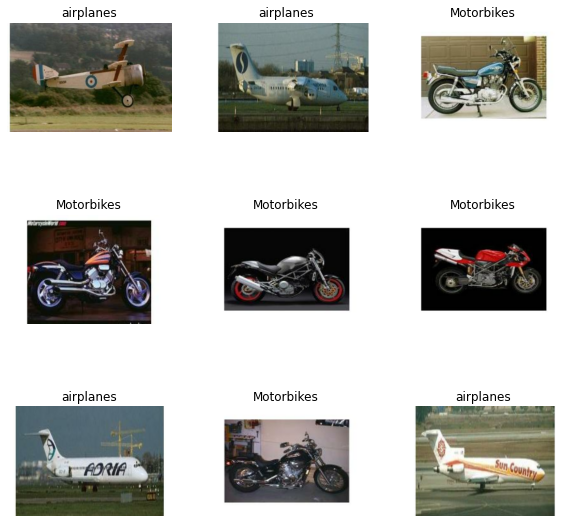

In [11]:
# preview the data
# src: https://www.tensorflow.org/tutorials/load_data/images
def preview_data(dataset):
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

preview_data(train_data)
preview_data(test_data)

In [8]:
# Configure the dataset for performance
# src: https://www.tensorflow.org/tutorials/load_data/images

#AUTOTUNE = tf.data.AUTOTUNE
#train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
#test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# create and apply a model
# src: https://www.tensorflow.org/tutorials/load_data/images

num_classes = len(class_names)
num_epochs = 10

#model = tf.keras.Sequential([
#  tf.keras.layers.Rescaling(1./255),                      # scale input values down from rgb(0-255) to [0-1]
#  tf.keras.layers.Conv2D(32, 3, activation='relu'),
#  tf.keras.layers.MaxPooling2D(),
#  tf.keras.layers.Conv2D(32, 3, activation='relu'),
#  tf.keras.layers.MaxPooling2D(),
#  tf.keras.layers.Conv2D(32, 3, activation='relu'),
#  tf.keras.layers.MaxPooling2D(),
#  tf.keras.layers.Flatten(),
#  tf.keras.layers.Dense(128, activation='relu'),
#  tf.keras.layers.Dense(num_classes)
#])

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),                      # scale input values down from rgb(0-255) to [0-1]
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)


In [16]:
history = model.fit(
  train_data,
  validation_data=test_data,
  epochs=num_epochs
)

model.summary()

#print(history.history.keys())

32/32 [==============================] - 65s 2s/step - loss: 0.5821 - accuracy: 0.8054 - val_loss: 0.0711 - val_accuracy: 0.9774
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 200, 300, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 198, 298, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 99, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 97, 147, 32)       4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 73, 32)       0         
 g2D)                                                    

In [ ]:
# visualize the performance history
# src: https://towardsdatascience.com/how-to-train-a-classification-model-with-tensorflow-in-10-minutes-fd2b7cfba86

rcParams['figure.figsize'] = (18, 8)

plt.plot(
    history.history['loss'], label='Training Loss'
)
plt.plot(
    history.history['val_loss'], label='Validation Loss'
)
plt.plot(
    history.history['accuracy'], label='Training Accuracy'
)
plt.plot(
    history.history['val_accuracy'], label='Validation Accuracy'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();
plt.show()

1/1 [==============================] - 0s 40ms/step
Examples: Correctly Classified
Examples: Incorrectly Classified


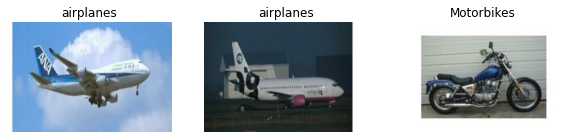

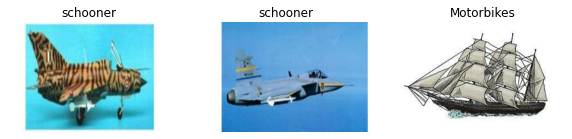

In [23]:
# Using the model, show the first 3 correctly classified, and incorrectly classified, from the validation set

#i=0
#for x in test_data:
#  if i<3:
#    print(x)
#  i += 1

good = []
bad = []

#for images, labels in test_data.take(1):
for step, (images_batch, labels_batch) in enumerate(test_data):
  if len(bad) > 2 and len(good) > 2:
    break
  for i in range(32):
    img_array = tf.expand_dims(images_batch[i], 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = np.argmax(score)
    if labels_batch[i] == predicted_class:
      good.append((images_batch[i], predicted_class))
    else:
      bad.append((images_batch[i], predicted_class))
    if len(bad) > 2 and len(good) > 2:
      break

#print('Found {} good and {} bad predictions'.format(len(good), len(bad)))

plt.figure(figsize=(10, 10))
print('Examples: Correctly Classified')
i=0
for item in good:
  if i<3:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(item[0].numpy().astype("uint8"))
    plt.title(class_names[item[1]])
    plt.axis("off")
    i += 1

plt.figure(figsize=(10, 10))
print('Examples: Incorrectly Classified')
i=0
for item in bad:
  if i<3:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(item[0].numpy().astype("uint8"))
    plt.title(class_names[item[1]])
    plt.axis("off")
    i += 1
